In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import time

In [ ]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


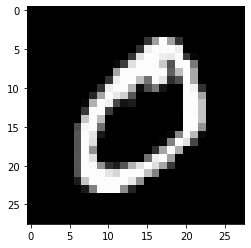

In [ ]:
plt.imshow(train_images[1], cmap='gray')

In [ ]:
# Normalization
train_images= (train_images-127.5)/127.5

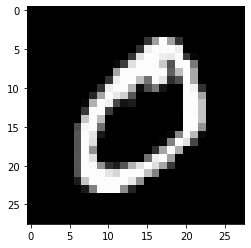

In [ ]:
plt.imshow(train_images[1],cmap='gray')

In [ ]:
# Expanding dimensions
train_images = train_images.reshape(train_images.shape[0],28,28,1)
train_images.shape

(60000, 28, 28, 1)

In [ ]:
# Defining parameters
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [ ]:
# Batchwise shuffling of the dataset
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

### Discriminator

In [ ]:
#CNN model
def discriminator():
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Conv2D(7,(3,3),padding='same',input_shape=(28,28,1)))
  model.add(tf.keras.layers.Conv2D(7,(3,3),padding='same'))
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(50,activation='relu'))
  model.add(tf.keras.layers.Dense(1))
  return model

In [ ]:
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [ ]:
# loss function for the discriminator
def discriminator_loss(real_predictions, fake_predictions):
  real_predictions = tf.sigmoid(real_predictions)
  fake_predictions = tf.sigmoid(fake_predictions)

  #computing binary cross entropy loss
  real_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(real_predictions), real_predictions)
  fake_loss = tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_predictions),fake_predictions)

  #returning final losses
  if real_loss.shape == fake_loss.shape:
    return real_loss+fake_loss
  else:
    return fake_loss+0.1

In [ ]:
discriminator().summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 7)         70        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 7)         448       
_________________________________________________________________
flatten (Flatten)            (None, 5488)              0         
_________________________________________________________________
dense (Dense)                (None, 50)                274450    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 275,019
Trainable params: 275,019
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def generator():
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Dense(7*7*256,input_shape =(100,)))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Dense(7*7*256))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Reshape( (7,7,256) ))
  model.add(tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same'))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same'))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same'))
  return model

In [ ]:
def generator_loss(fake_predictions):
  fake_predictions = tf.sigmoid(fake_predictions)
  fake_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(fake_predictions),fake_predictions)
  return fake_loss

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [ ]:
generator_model= generator()
discriminator_model = discriminator()

### Training

In [ ]:
def train(data, epochs):
  for i in range(epochs):
    for images in data:
      images = tf.cast(images,tf.dtypes.float32)
      train_step(images)

In [ ]:
def train_step(images):
  noise = np.random.randn(BATCH_SIZE, 100).astype('float32')
  # batchwise training
  with tf.GradientTape() as generator_tape, tf.GradientTape() as discriminator_tape:
        # Create fake images
        generated_images = generator_model(noise)
        # Pass fake images through the discriminator
        generator_output = discriminator_model(generated_images)
        # Pass real images through the discriminator
        real_output = discriminator_model(images)

        # calculate individual losses
        gen_loss = generator_loss(generator_output)
        disc_loss = discriminator_loss(real_output, generator_output)

        # Calculate gradients of loss functions
        generator_gradients= generator_tape.gradient(gen_loss,generator_model.trainable_variables)
        discriminator_gradients = discriminator_tape.gradient(disc_loss, discriminator_model.trainable_variables)

        # Optimise
        generator_optimizer.apply_gradients(zip(generator_gradients, generator_model.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator_model.trainable_variables))

        print("Generator Loss: ",np.mean(gen_loss))
        print("Discriminator Loss: ",np.mean(disc_loss))



In [ ]:
train(train_dataset,100)

Streaming output truncated to the last 5000 lines.
Generator Loss:  5.9651165
Discriminator Loss:  9.40359
Generator Loss:  6.3868923
Discriminator Loss:  8.9843235
Generator Loss:  5.5433407
Discriminator Loss:  9.822859
Generator Loss:  6.085624
Discriminator Loss:  9.2838
Generator Loss:  5.663848
Discriminator Loss:  9.703068
Generator Loss:  6.5676537
Discriminator Loss:  8.804637
Generator Loss:  5.8446097
Discriminator Loss:  9.523382
Generator Loss:  5.5433407
Discriminator Loss:  9.82286
Generator Loss:  5.8446093
Discriminator Loss:  9.523382
Generator Loss:  6.6279078
Discriminator Loss:  8.744741
Generator Loss:  5.181819
Discriminator Loss:  10.182232
Generator Loss:  6.326639
Discriminator Loss:  9.144216
Generator Loss:  5.724102
Discriminator Loss:  9.643172
Generator Loss:  5.181819
Discriminator Loss:  10.182232
Generator Loss:  6.4471464
Discriminator Loss:  8.924428
Generator Loss:  6.145878
Discriminator Loss:  9.223905
Generator Loss:  5.603595
Discriminator Loss:

In [ ]:
test_image_noise = np.random.randn(1,100)
generated_test_image = generator_model(test_image_noise)
plt.imshow(tf.reshape(generated_test_image,(28,28)),cmap='gray')

In [ ]:
random_image = np.random.randn(784)
random_image = tf.reshape(random_image,(28,28))
plt.imshow(random_image,cmap='gray')